In [72]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
from sympy.strategies.branch import do_one

n_actions = 2
learning_rate = 0.1
discount_factor = 0.99
epsilon = 1
epochs = 1000

theta_bins = [-12, -6, -1, 0, 1, 6, 12]  # θ: 0, ±1, ±6, ±12
x_bins = [-2.4, -0.8, 0.8, 2.4]  # x: ±0.8, ±2.4 
theta_dot_bins = [-np.inf, -50, 50, np.inf]  # θ̇: ±50, inf
x_dot_bins = [-np.inf, -0.5, 0.5, np.inf]  # ẋ: ±0.5, inf

# Q table
Q = np.zeros((len(theta_bins)-1, len(x_bins)-1, len(theta_dot_bins)-1,
              len(x_dot_bins)-1, n_actions))

In [105]:
def discretize_state(state):
    theta, x, theta_dot, x_dot = state
    theta_idx = np.digitize(theta, theta_bins) - 1
    x_idx = np.digitize(x, x_bins) - 1
    theta_dot_idx = np.digitize(theta_dot, theta_dot_bins) - 1
    x_dot_idx = np.digitize(x_dot, x_dot_bins) - 1
    
    return theta_idx, x_idx, theta_dot_idx, x_dot_idx

def isTerminal(state, time):
    theta, x, theta_dot, x_dot = state
    if abs(theta) > 12 or abs(x) > 2.4 or abs(theta_dot) > 50 or abs(x_dot) > 0.5 or time > 200:
        return True
    else:
        return False

def train():
    rewards = []
    for episode in range(epochs):
        state,_ = env.reset()
        state = discretize_state(state)
        done = False
        total_reward = 0
        time = 0

        while not done:
            # epsilon-greedy
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()  
            else:
                action = np.argmax(Q[state])
            
            next_state, reward, _, _, _ = env.step(action)
            done = isTerminal(next_state,time)

            next_state = discretize_state(next_state)
            

            
            # update Q
            Q[state][action] = Q[state][action] + learning_rate * (
                reward + discount_factor * np.max(Q[next_state]) - Q[state][action]
            )

            state = next_state
            total_reward += reward
            time += 1
            


        rewards.append(total_reward)

        if (episode + 1) % 100 == 0:
            print(f"Episode {episode+1}/{epochs}, Total reward: {total_reward}")

    return rewards


def test():
    state,_ = env.reset()
    if isinstance(state, dict):
        state = state['state']
    state = discretize_state(state)
    done = False
    total_reward = 0

    while not done:
        action = np.argmax(Q[state])  
        next_state, reward, done, _, _ = env.step(action)
        if isinstance(next_state, dict):
            next_state = next_state['state']
        next_state = discretize_state(next_state)
        state = next_state
        total_reward += reward

    print(f"Test Total Reward: {total_reward}")

In [106]:
env = gym.make('CartPole-v0')
rewards = train()
test()

Episode 100/1000, Total reward: 2.0
Episode 200/1000, Total reward: 8.0
Episode 300/1000, Total reward: 2.0
Episode 400/1000, Total reward: 2.0
Episode 500/1000, Total reward: 4.0
Episode 600/1000, Total reward: 6.0
Episode 700/1000, Total reward: 6.0
Episode 800/1000, Total reward: 2.0
Episode 900/1000, Total reward: 2.0
Episode 1000/1000, Total reward: 2.0
Test Total Reward: 18.0


In [93]:
print(env.observation_space)
env.close()

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


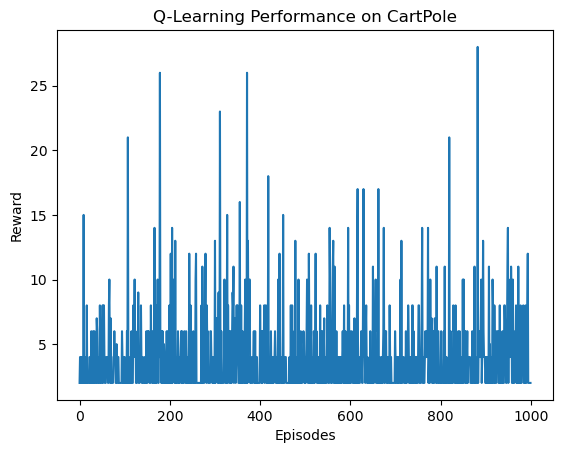

In [107]:
plt.plot(rewards)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Q-Learning Performance on CartPole')
plt.show()